# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.358289
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.119280 analytic: 1.119280, relative error: 3.012888e-08
numerical: 0.353153 analytic: 0.353153, relative error: 1.818130e-07
numerical: 0.172445 analytic: 0.172445, relative error: 2.206124e-07
numerical: 0.848805 analytic: 0.848805, relative error: 4.224434e-08
numerical: -1.309381 analytic: -1.309381, relative error: 3.135174e-08
numerical: -1.468088 analytic: -1.468088, relative error: 1.374628e-08
numerical: 3.796667 analytic: 3.796667, relative error: 1.464495e-08
numerical: 1.683693 analytic: 1.683693, relative error: 3.792456e-08
numerical: -0.628918 analytic: -0.628918, relative error: 3.791092e-08
numerical: 3.850628 analytic: 3.850628, relative error: 1.490845e-08
numerical: -1.713647 analytic: -1.709820, relative error: 1.117922e-03
numerical: -0.386978 analytic: -0.388654, relative error: 2.161447e-03
numerical: -0.180648 analytic: -0.183672, relative error: 8.298563e-03
numerical: -0.489884 analytic: -0.488807, relative error: 1.100118e-03
numerical: -3.139295

In [6]:
from cs231n.classifiers.softmax import softmax_loss_vectorized

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.403240 analytic: 1.403240, relative error: 2.326433e-08
numerical: -1.307962 analytic: -1.307962, relative error: 1.605338e-08
numerical: -1.870781 analytic: -1.870781, relative error: 3.666443e-08
numerical: 2.055705 analytic: 2.055704, relative error: 3.741702e-08
numerical: -1.920565 analytic: -1.920565, relative error: 1.325568e-08
numerical: -3.160442 analytic: -3.160442, relative error: 3.855796e-09
numerical: 1.518385 analytic: 1.518384, relative error: 5.348498e-08
numerical: -0.136574 analytic: -0.136574, relative error: 1.289730e-07
numerical: -3.796640 analytic: -3.796640, relative error: 2.345672e-09
numerical: -0.858138 analytic: -0.858138, relative error: 4.533235e-09
numerical: 4.551422 analytic: 4.558458, relative error: 7.723071e-04
numerical: 1.168516 analytic: 1.174512, relative error: 2.559204e-03
numerical: 2.908786 analytic: 2.916304, relative error: 1.290649e-03
numerical: -5.611673 analytic: -5.604999, relative error: 5.950383e-04
numerical: 1.62145

In [7]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.358289e+00 computed in 0.119782s
vectorized loss: 2.358289e+00 computed in 0.006681s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [5e4, 1e8]

learning_rates = [2.8e-6, 1e-7]
regularization_strengths = [1e+03, 5e4]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

## Converting the learning rate and regularization strenghts list into numpy arrays.
learning_rates = np.array(learning_rates)
regularization_strengths = np.array(regularization_strengths)

## Creating a grid search array which contains the different hyperparameter combinations.
gridArray = np.array(np.meshgrid(learning_rates, regularization_strengths)).T.reshape(4, 2)

## Iterating over each hyperparameter combination.
for i in range(gridArray.shape[0]):
    
    ## Setting the learning rate and the regularisation strength.
    learning_rate = gridArray[i][0]
    regularization_strength = gridArray[i][1]
    
    ## Instantiating the model.
    softmaxModel = Softmax()
    
    ## Training the model on the training data.
    softmaxModel.train(X_train, y_train, learningRate = learning_rate, reg = regularization_strength, numIters = 1000)
    
    ## Training Predictions.
    yPredTrain = softmaxModel.predict(X_train)
    
    ## Validation Predictions.
    yPredValidation = softmaxModel.predict(X_val)
    
    ## Computing training accuracy.
    trainAccuracy = np.mean(yPredTrain == y_train)
    
    ## Computing validation accuracy.
    validationAccuracy = np.mean(yPredValidation == y_val)
    
    ## Comparing the current validation accuracy with the previous one.
    if (validationAccuracy > best_val):
        
        best_val = validationAccuracy
        best_softmax = softmaxModel
        
    results[learning_rate, regularization_strength] = (trainAccuracy, validationAccuracy)

    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.226531 val accuracy: 0.236000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.230918 val accuracy: 0.231000
lr 2.800000e-06 reg 1.000000e+03 train accuracy: 0.367531 val accuracy: 0.369000
lr 2.800000e-06 reg 5.000000e+04 train accuracy: 0.394857 val accuracy: 0.401000
best validation accuracy achieved during cross-validation: 0.401000


In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.368000


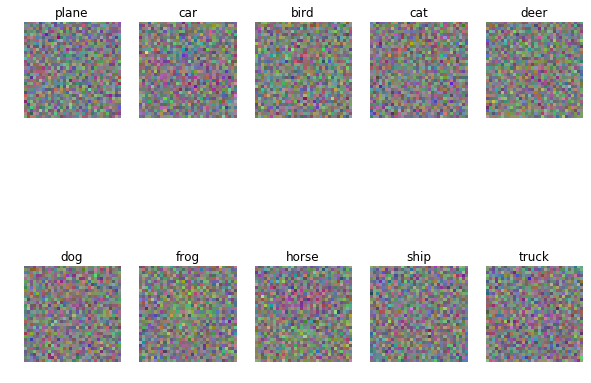

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])